In [1]:
import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from pandas.core.groupby.generic import DataFrameGroupBy
from icecream import ic
import re
import sys
sys.path.append("..")
from fpl.pipelines.model_pipeline.preprocessing.elo_calculation import calculate_elo_score
import matplotlib.pyplot as plt


In [2]:
conn = sqlite3.connect("../data/fpl.db")
train_val_data = pd.read_sql(f"select * from train_val_data", conn)
conn.close()
display(train_val_data.head())

,season,fpl_name,round,date,player,venue,team,opponent,pos,value,...,match_points_ma2,match_points_ma3,match_points_ma4,match_points_ma5,league_points_ma1,league_points_ma2,league_points_ma3,league_points_ma4,league_points_ma5,fpl_points
0,2016-2017,Aaron Lennon,1.0,2016-08-13 00:00:00.000000,Aaron Lennon,Home,Everton,Tottenham,MF,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2016-2017,Marten de Roon,1.0,2016-08-13 00:00:00.000000,Marten de Roon,Home,Middlesbrough,Stoke City,DM,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2016-2017,Martin Kelly,1.0,2016-08-13 00:00:00.000000,Martin Kelly,Home,Crystal Palace,West Brom,DF,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2016-2017,Mason Holgate,1.0,2016-08-13 00:00:00.000000,Mason Holgate,Home,Everton,Tottenham,CB,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2016-2017,Matt Phillips,1.0,2016-08-13 00:00:00.000000,Matt Phillips,Away,West Brom,Crystal Palace,RM,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [18]:
X_train_val = train_val_data[["round","value","att_total","home_att_total","away_att_total","def_total","home_def_total","away_def_total","pts_b4_match","rank_b4_match","pts_gap_above","pts_gap_below","min_ma1","gls_ma1","ast_ma1","pk_ma1","pkatt_ma1","sh_ma1","sot_ma1","touches_ma1","xg_ma1","npxg_ma1","xag_ma1","sca_ma1","gca_ma1","sota_ma1","ga_ma1","saves_ma1","savepct_ma1","cs_ma1","psxg_ma1","team_poss_ma1","team_gf_ma1","team_ga_ma1","team_xg_ma1","team_xga_ma1","fpl_points_ma1","value_ma1","att_elo_ma1","def_elo_ma1","home_att_elo_ma1","home_def_elo_ma1","away_att_elo_ma1","away_def_elo_ma1","att_elo_opp_ma1","def_elo_opp_ma1","home_att_elo_opp_ma1","home_def_elo_opp_ma1","away_att_elo_opp_ma1","away_def_elo_opp_ma1","att_total_ma1","home_att_total_ma1","away_att_total_ma1","def_total_ma1","home_def_total_ma1","away_def_total_ma1","match_points_ma1","league_points_ma1","min_ma2","gls_ma2","ast_ma2","pk_ma2","pkatt_ma2","sh_ma2","sot_ma2","touches_ma2","xg_ma2","npxg_ma2","xag_ma2","sca_ma2","gca_ma2","sota_ma2","ga_ma2","saves_ma2","savepct_ma2","cs_ma2","psxg_ma2","team_poss_ma2","team_gf_ma2","team_ga_ma2","team_xg_ma2","team_xga_ma2","fpl_points_ma2","value_ma2","att_elo_ma2","def_elo_ma2","home_att_elo_ma2","home_def_elo_ma2","away_att_elo_ma2","away_def_elo_ma2","att_elo_opp_ma2","def_elo_opp_ma2","home_att_elo_opp_ma2","home_def_elo_opp_ma2","away_att_elo_opp_ma2","away_def_elo_opp_ma2","att_total_ma2","home_att_total_ma2","away_att_total_ma2","def_total_ma2","home_def_total_ma2","away_def_total_ma2","match_points_ma2","league_points_ma2","min_ma3","gls_ma3","ast_ma3","pk_ma3","pkatt_ma3","sh_ma3","sot_ma3","touches_ma3","xg_ma3","npxg_ma3","xag_ma3","sca_ma3","gca_ma3","sota_ma3","ga_ma3","saves_ma3","savepct_ma3","cs_ma3","psxg_ma3","team_poss_ma3","team_gf_ma3","team_ga_ma3","team_xg_ma3","team_xga_ma3","fpl_points_ma3","value_ma3","att_elo_ma3","def_elo_ma3","home_att_elo_ma3","home_def_elo_ma3","away_att_elo_ma3","away_def_elo_ma3","att_elo_opp_ma3","def_elo_opp_ma3","home_att_elo_opp_ma3","home_def_elo_opp_ma3","away_att_elo_opp_ma3","away_def_elo_opp_ma3","att_total_ma3","home_att_total_ma3","away_att_total_ma3","def_total_ma3","home_def_total_ma3","away_def_total_ma3","match_points_ma3","league_points_ma3","min_ma4","gls_ma4","ast_ma4","pk_ma4","pkatt_ma4","sh_ma4","sot_ma4","touches_ma4","xg_ma4","npxg_ma4","xag_ma4","sca_ma4","gca_ma4","sota_ma4","ga_ma4","saves_ma4","savepct_ma4","cs_ma4","psxg_ma4","team_poss_ma4","team_gf_ma4","team_ga_ma4","team_xg_ma4","team_xga_ma4","fpl_points_ma4","value_ma4","att_elo_ma4","def_elo_ma4","home_att_elo_ma4","home_def_elo_ma4","away_att_elo_ma4","away_def_elo_ma4","att_elo_opp_ma4","def_elo_opp_ma4","home_att_elo_opp_ma4","home_def_elo_opp_ma4","away_att_elo_opp_ma4","away_def_elo_opp_ma4","att_total_ma4","home_att_total_ma4","away_att_total_ma4","def_total_ma4","home_def_total_ma4","away_def_total_ma4","match_points_ma4","league_points_ma4","min_ma5","gls_ma5","ast_ma5","pk_ma5","pkatt_ma5","sh_ma5","sot_ma5","touches_ma5","xg_ma5","npxg_ma5","xag_ma5","sca_ma5","gca_ma5","sota_ma5","ga_ma5","saves_ma5","savepct_ma5","cs_ma5","psxg_ma5","team_poss_ma5","team_gf_ma5","team_ga_ma5","team_xg_ma5","team_xga_ma5","fpl_points_ma5","value_ma5","att_elo_ma5","def_elo_ma5","home_att_elo_ma5","home_def_elo_ma5","away_att_elo_ma5","away_def_elo_ma5","att_elo_opp_ma5","def_elo_opp_ma5","home_att_elo_opp_ma5","home_def_elo_opp_ma5","away_att_elo_opp_ma5","away_def_elo_opp_ma5","att_total_ma5","home_att_total_ma5","away_att_total_ma5","def_total_ma5","home_def_total_ma5","away_def_total_ma5","match_points_ma5","league_points_ma5"]]
y_train_val = train_val_data["fpl_points"]

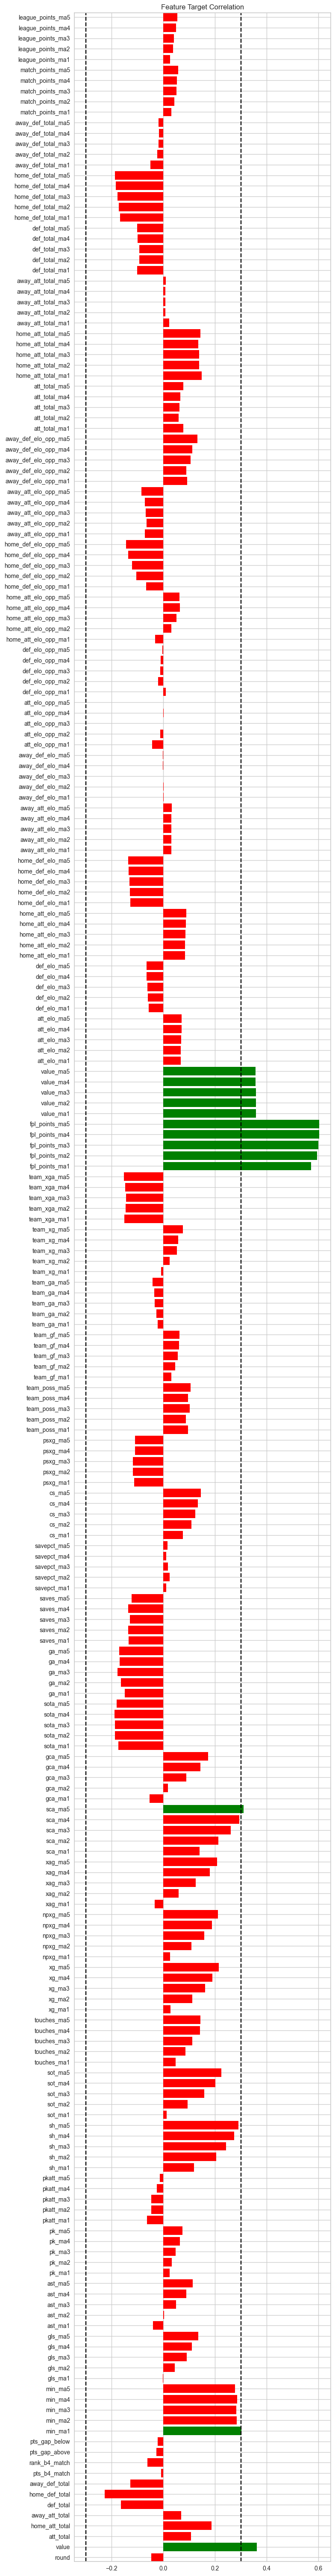

In [33]:
from scipy.stats import f, pearsonr, spearmanr
import matplotlib.pyplot as plt

def f_test(X, y, mode):
    # Do F-test using Pearson correlation
    temp = []
    for col in X.columns:
        valid_indices = ~np.isnan(X[col].values)
        valid_x = X[col].values[valid_indices]
        valid_y = y[valid_indices]
        if mode.lower() == "pearsonr":
            corr, _ = pearsonr(valid_x, valid_y)
        elif mode.lower() == "spearmanr":
            corr, _ = spearmanr(valid_x, valid_y)
        else:
            raise Exception("Incorrect mode")
        temp.append(corr)

    return pd.Series(temp, index=X.columns)
    
def plot_h_bars(threshold, checks, series, mode):
    height = max(4, len(series) * 0.25)
    fig, ax = plt.subplots(
        figsize=(8, height),
    )
    if mode == "variance":
        colors = ["green" if value else "red" for value in checks.values]
        ax.axvline(x=threshold, color="black", linestyle="--")
        ax.set_title("Features Variances")
    elif mode == "f_test":
        colors = [
            "green" if var >= threshold or var <= -threshold else "red"
            for var in series.values
        ]
        ax.axvline(x=threshold, color="black", linestyle="--")
        ax.axvline(x=-threshold, color="black", linestyle="--")
        ax.set_title("Feature Target Correlation")
    ax.barh(series.index, series.values, color=colors)
    ax.margins(y=0)
    fig.tight_layout()
    return fig

numerical_data = X_train_val[['round', 'value', 'att_total', 'home_att_total', 'away_att_total', 'def_total', 'home_def_total', 'away_def_total', 'pts_b4_match', 'rank_b4_match', 'pts_gap_above', 'pts_gap_below', 'min_ma1', 'min_ma2', 'min_ma3', 'min_ma4', 'min_ma5', 'gls_ma1', 'gls_ma2', 'gls_ma3', 'gls_ma4', 'gls_ma5', 'ast_ma1', 'ast_ma2', 'ast_ma3', 'ast_ma4', 'ast_ma5', 'pk_ma1', 'pk_ma2', 'pk_ma3', 'pk_ma4', 'pk_ma5', 'pkatt_ma1', 'pkatt_ma2', 'pkatt_ma3', 'pkatt_ma4', 'pkatt_ma5', 'sh_ma1', 'sh_ma2', 'sh_ma3', 'sh_ma4', 'sh_ma5', 'sot_ma1', 'sot_ma2', 'sot_ma3', 'sot_ma4', 'sot_ma5', 'touches_ma1', 'touches_ma2', 'touches_ma3', 'touches_ma4', 'touches_ma5', 'xg_ma1', 'xg_ma2', 'xg_ma3', 'xg_ma4', 'xg_ma5', 'npxg_ma1', 'npxg_ma2', 'npxg_ma3', 'npxg_ma4', 'npxg_ma5', 'xag_ma1', 'xag_ma2', 'xag_ma3', 'xag_ma4', 'xag_ma5', 'sca_ma1', 'sca_ma2', 'sca_ma3', 'sca_ma4', 'sca_ma5', 'gca_ma1', 'gca_ma2', 'gca_ma3', 'gca_ma4', 'gca_ma5', 'sota_ma1', 'sota_ma2', 'sota_ma3', 'sota_ma4', 'sota_ma5', 'ga_ma1', 'ga_ma2', 'ga_ma3', 'ga_ma4', 'ga_ma5', 'saves_ma1', 'saves_ma2', 'saves_ma3', 'saves_ma4', 'saves_ma5', 'savepct_ma1', 'savepct_ma2', 'savepct_ma3', 'savepct_ma4', 'savepct_ma5', 'cs_ma1', 'cs_ma2', 'cs_ma3', 'cs_ma4', 'cs_ma5', 'psxg_ma1', 'psxg_ma2', 'psxg_ma3', 'psxg_ma4', 'psxg_ma5', 'team_poss_ma1', 'team_poss_ma2', 'team_poss_ma3', 'team_poss_ma4', 'team_poss_ma5', 'team_gf_ma1', 'team_gf_ma2', 'team_gf_ma3', 'team_gf_ma4', 'team_gf_ma5', 'team_ga_ma1', 'team_ga_ma2', 'team_ga_ma3', 'team_ga_ma4', 'team_ga_ma5', 'team_xg_ma1', 'team_xg_ma2', 'team_xg_ma3', 'team_xg_ma4', 'team_xg_ma5', 'team_xga_ma1', 'team_xga_ma2', 'team_xga_ma3', 'team_xga_ma4', 'team_xga_ma5', 'fpl_points_ma1', 'fpl_points_ma2', 'fpl_points_ma3', 'fpl_points_ma4', 'fpl_points_ma5', 'value_ma1', 'value_ma2', 'value_ma3', 'value_ma4', 'value_ma5', 'att_elo_ma1', 'att_elo_ma2', 'att_elo_ma3', 'att_elo_ma4', 'att_elo_ma5', 'def_elo_ma1', 'def_elo_ma2', 'def_elo_ma3', 'def_elo_ma4', 'def_elo_ma5', 'home_att_elo_ma1', 'home_att_elo_ma2', 'home_att_elo_ma3', 'home_att_elo_ma4', 'home_att_elo_ma5', 'home_def_elo_ma1', 'home_def_elo_ma2', 'home_def_elo_ma3', 'home_def_elo_ma4', 'home_def_elo_ma5', 'away_att_elo_ma1', 'away_att_elo_ma2', 'away_att_elo_ma3', 'away_att_elo_ma4', 'away_att_elo_ma5', 'away_def_elo_ma1', 'away_def_elo_ma2', 'away_def_elo_ma3', 'away_def_elo_ma4', 'away_def_elo_ma5', 'att_elo_opp_ma1', 'att_elo_opp_ma2', 'att_elo_opp_ma3', 'att_elo_opp_ma4', 'att_elo_opp_ma5', 'def_elo_opp_ma1', 'def_elo_opp_ma2', 'def_elo_opp_ma3', 'def_elo_opp_ma4', 'def_elo_opp_ma5', 'home_att_elo_opp_ma1', 'home_att_elo_opp_ma2', 'home_att_elo_opp_ma3', 'home_att_elo_opp_ma4', 'home_att_elo_opp_ma5', 'home_def_elo_opp_ma1', 'home_def_elo_opp_ma2', 'home_def_elo_opp_ma3', 'home_def_elo_opp_ma4', 'home_def_elo_opp_ma5', 'away_att_elo_opp_ma1', 'away_att_elo_opp_ma2', 'away_att_elo_opp_ma3', 'away_att_elo_opp_ma4', 'away_att_elo_opp_ma5', 'away_def_elo_opp_ma1', 'away_def_elo_opp_ma2', 'away_def_elo_opp_ma3', 'away_def_elo_opp_ma4', 'away_def_elo_opp_ma5', 'att_total_ma1', 'att_total_ma2', 'att_total_ma3', 'att_total_ma4', 'att_total_ma5', 'home_att_total_ma1', 'home_att_total_ma2', 'home_att_total_ma3', 'home_att_total_ma4', 'home_att_total_ma5', 'away_att_total_ma1', 'away_att_total_ma2', 'away_att_total_ma3', 'away_att_total_ma4', 'away_att_total_ma5', 'def_total_ma1', 'def_total_ma2', 'def_total_ma3', 'def_total_ma4', 'def_total_ma5', 'home_def_total_ma1', 'home_def_total_ma2', 'home_def_total_ma3', 'home_def_total_ma4', 'home_def_total_ma5', 'away_def_total_ma1', 'away_def_total_ma2', 'away_def_total_ma3', 'away_def_total_ma4', 'away_def_total_ma5', 'match_points_ma1', 'match_points_ma2', 'match_points_ma3', 'match_points_ma4', 'match_points_ma5', 'league_points_ma1', 'league_points_ma2', 'league_points_ma3', 'league_points_ma4', 'league_points_ma5']]
variance_threshold = 0.3
f_test_correlation = f_test(
        numerical_data, y_train_val, "spearmanr"
    )
f_test_check = abs(f_test_correlation) >= variance_threshold
fig = plot_h_bars(variance_threshold, f_test_check, f_test_correlation, mode="f_test")
plt.show()

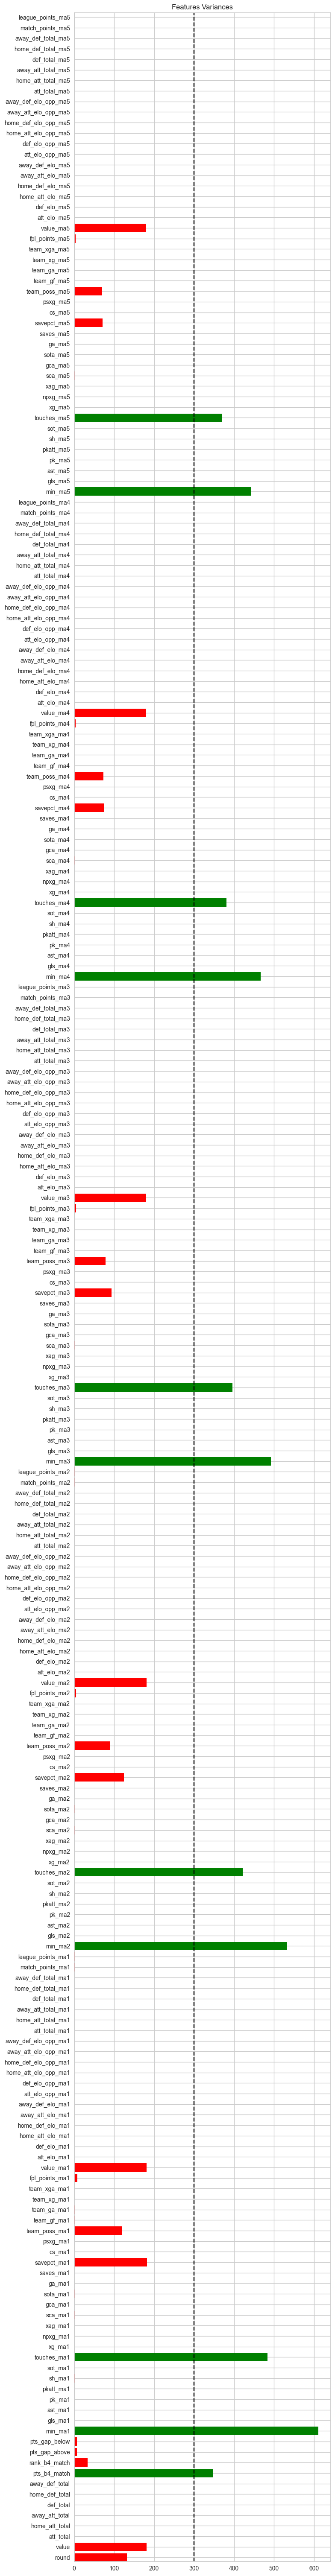

In [17]:
numerical = X_train_val.var()
variance_threshold = 300
plt = plot_variances(variance_threshold, variances)
plt.show()
